In [2]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from online.envs.bidding_env import BiddingEnv
from definitions import ROOT_DIR, ENV_CONFIG_NAME
import json
from online.envs.environment_factory import EnvironmentFactory
from online.helpers import (
    load_model,
    load_vecnormalize,
)


In [3]:
path = ROOT_DIR / "data/results/eval_dense.json"
with open(path, "r") as f:
    data = json.load(f)
    
for key, value in data.items():
    score_list = []
    cost_over_budget_list = []
    target_cpa_over_cpa_list = []
    for exp in value:
        score_list.append(exp["score"]["mean"])
        cost_over_budget_list.append(exp["cost_over_budget"]["mean"])
        target_cpa_over_cpa_list.append(exp["target_cpa_over_cpa"]["mean"])
    print(key, "score, mean:", np.mean(score_list), "sem:", np.std(score_list) / np.sqrt(len(score_list)))
    print(key, "cost_over_budget, mean:", np.mean(cost_over_budget_list), "sem:", np.std(cost_over_budget_list) / np.sqrt(len(cost_over_budget_list)))
    print(key, "target_cpa_over_cpa, mean:", np.mean(target_cpa_over_cpa_list), "sem:", np.std(target_cpa_over_cpa_list) / np.sqrt(len(target_cpa_over_cpa_list)))
    

ppo_sparse score, mean: 381.97355311135317 sem: 10.488324261691922
ppo_sparse cost_over_budget, mean: 0.8220034828703601 sem: 0.018733193313775306
ppo_sparse target_cpa_over_cpa, mean: 0.9078177481223705 sem: 0.019355013802386363
ppo_dense score, mean: 384.71483041739765 sem: 13.122858104881388
ppo_dense cost_over_budget, mean: 0.8717259477051423 sem: 0.03976688934857355
ppo_dense target_cpa_over_cpa, mean: 0.907091685798878 sem: 0.024964675779883087
ppo_dense_2_slopes score, mean: 291.5826132472817 sem: 22.40997651749159
ppo_dense_2_slopes cost_over_budget, mean: 0.7811251601010305 sem: 0.021980192838642817
ppo_dense_2_slopes target_cpa_over_cpa, mean: 0.8145846478784388 sem: 0.02082878467962609
oil score, mean: 466.3627880665622 sem: 0.433743930607874
oil cost_over_budget, mean: 0.9870796358164905 sem: 0.0030208227958212664
oil target_cpa_over_cpa, mean: 0.9773958192899498 sem: 0.000761966790040877
oil_2_slopes score, mean: 459.2124847626387 sem: 9.427049571448727
oil_2_slopes cost_o

In [4]:
pvalues_path = ROOT_DIR / "data" / "traffic" / "online_rl_data_dense" / "period-27_pvalues.parquet"
bids_path = ROOT_DIR / "data" / "traffic" / "online_rl_data_dense" / "period-27_bids.parquet"
budget_range = (2000, 5000)
target_cpa_range = (60, 130)
seed = 0
pv_range_list = list(np.linspace(0, 0.005, 101))
with open(ROOT_DIR / "data" / "obs_configs" / f"obs_60_keys.json", "r") as f:
    obs_keys = json.load(f)
env = BiddingEnv(pvalues_path, bids_path, budget_range, target_cpa_range, obs_keys=obs_keys, 
                 seed=seed, deterministic_conversion=True, single_io_bid=True, oracle_upgrade=True)

Loading pvalues from /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/traffic/online_rl_data_dense/period-27_pvalues.parquet


Loading bids from /home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/data/traffic/online_rl_data_dense/period-27_bids.parquet


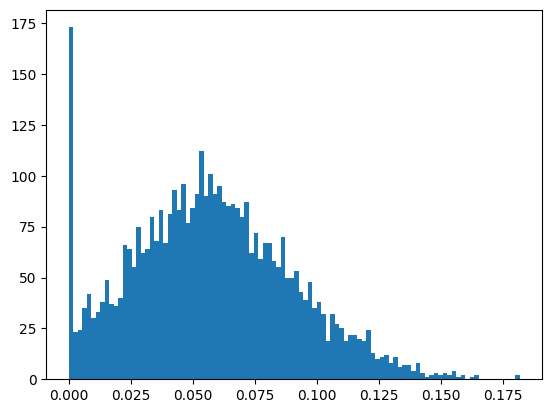

In [6]:
# Plot pv / cost over time for one advertiser
advertiser_id = 0
ts = 10
t_cpa = 8

bids_df = env.bids_df_list[0]
pvalues_df = env.pvalues_df
pv_vec = pvalues_df[(pvalues_df.advertiserNumber == advertiser_id) & (pvalues_df.timeStepIndex == ts)].pValue.item()
bids_mat = bids_df[(bids_df.timeStepIndex == ts)].bid.item()
cost_mat = bids_df[(bids_df.timeStepIndex == ts)].cost.item()
ad_mat = bids_df[(bids_df.timeStepIndex == ts)].advertiserNumber.item()
bids_mat[ad_mat == advertiser_id] = cost_mat[ad_mat == advertiser_id]
cost_vec = bids_mat[:, 0]

# Plot hist of the pvalues
plt.hist(pv_vec / cost_vec, bins=100)
plt.show()

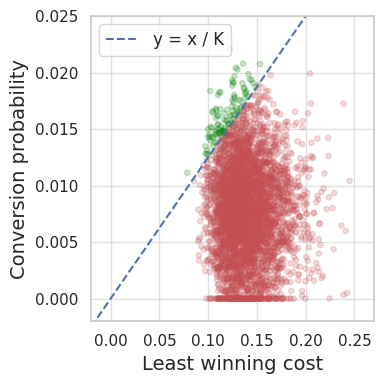

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

x_min = -0.02
y_min = -0.002
x_max = 0.27
y_max = 0.025

# Compute the decision boundary
xx = np.linspace(x_min, x_max, 100)
boundary_line = (1 / t_cpa) * xx

# Determine colors
colors = np.where(pv_vec > (1 / t_cpa) * cost_vec, 'green', 'r')

# Plot settings
sns.set_theme(style="whitegrid")
plt.figure(figsize=(4, 4))

# Scatter plot
scatter = plt.scatter(cost_vec, pv_vec, c=colors, s=15, alpha=0.2)

# Boundary line
plt.plot(xx, boundary_line, 'b--', label=f'y = x / K')

# Annotations
plt.xlabel('Least winning cost', fontsize=14)
plt.ylabel('Conversion probability', fontsize=14)
# plt.title('Scatterplot of Cost vs PV with Decision Boundary', fontsize=16)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(True, alpha=0.6)

# Reposition
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Show plot
plt.tight_layout()
plt.savefig(ROOT_DIR / "data" / "images" / "pv_vs_lwc.svg", format="svg")
plt.show()


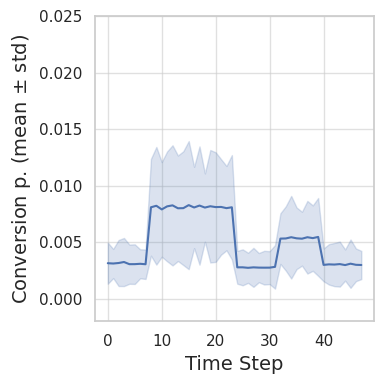

In [8]:
pv_time_series = pvalues_df[(pvalues_df.advertiserNumber == advertiser_id)].pValue.apply(np.mean)
pv_std_series = pvalues_df[(pvalues_df.advertiserNumber == advertiser_id)].pValue.apply(np.std)

# Plot settings
sns.set_theme(style="whitegrid")
plt.figure(figsize=(4, 4))

# Time series plot with shaded area
x = np.arange(len(pv_time_series))
plt.plot(x, pv_time_series, color='b')
plt.fill_between(x, pv_time_series - pv_std_series, pv_time_series + pv_std_series,
                 color='b', alpha=0.2)

# Annotations
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Conversion p. (mean $\pm$ std)', fontsize=14)
# plt.title('Time Series of Mean PV with Standard Deviation', fontsize=16)

# y range
plt.ylim(y_min, y_max)

# Legend and grid
plt.grid(True, alpha=0.6)

# Show plot
plt.tight_layout()
plt.savefig(ROOT_DIR / "data" / "images" / "pv_ts.svg", format="svg")
plt.show()

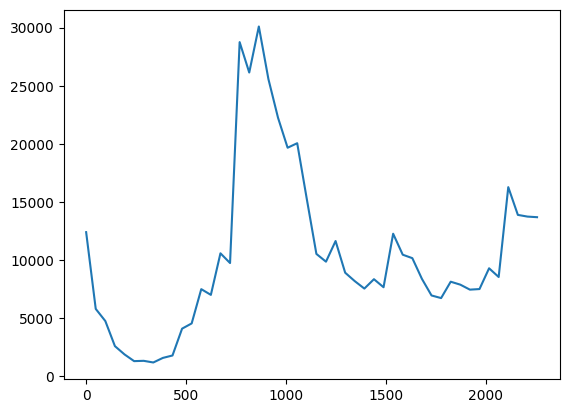

In [36]:
pv_time_series = pvalues_df[(pvalues_df.advertiserNumber == advertiser_id)].pValue.apply(lambda x: len(x))
plt.plot(pv_time_series)

In [4]:
df_path = ROOT_DIR / "data/traffic/raw_traffic_parquet/period-27.parquet"
df = pd.read_parquet(df_path)
df.keys()

Index(['deliveryPeriodIndex', 'advertiserNumber', 'advertiserCategoryIndex',
       'budget', 'CPAConstraint', 'timeStepIndex', 'remainingBudget',
       'pvIndex', 'pValue', 'pValueSigma', 'bid', 'xi', 'adSlot', 'cost',
       'isExposed', 'conversionAction', 'leastWinningCost', 'isEnd'],
      dtype='object')

In [10]:
df.budget.min(), df.budget.max()

(450.0, 11850.0)

In [11]:
df.CPAConstraint.min(), df.CPAConstraint.max()

(6.0, 12.0)

In [8]:
exp_path = "055_onbc_seed_0_single_io_bid_batch_state_20_envs_1000_subs"
checkpoint = 3650000

experiment_path = ROOT_DIR / "saved_model" / "ONBC" / exp_path
model = load_model(
    "oil",
    experiment_path,
    checkpoint,
)
train_env_config = json.load(open(experiment_path / ENV_CONFIG_NAME, "r"))
train_env_config["bids_df_path"] = None
train_env_config["pvalues_df_path"] = None
train_env = EnvironmentFactory.create(**train_env_config)
vecnormalize = load_vecnormalize(experiment_path, checkpoint, train_env)
vecnormalize.training = False


FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/Dev/NeurIPS_Auto_Bidding_General_Track_Baseline/saved_model/ONBC/055_onbc_seed_0_single_io_bid_batch_state_20_envs_1000_subs/rl_model_3650000_steps.zip.zip'

In [9]:
obs, _ = env.reset()
pvalues, pvalues_std = env.get_pvalues_mean_and_std()
state_dict = env.get_state_dict(pvalues, pvalues_std)
print(state_dict.keys())

dict_keys(['time_left', 'budget_left', 'budget', 'cpa', 'category', 'total_conversions', 'total_cost', 'total_cpa', 'pv_num_total', 'current_pvalues_mean', 'current_pvalues_90_pct', 'current_pvalues_99_pct', 'current_pv_num', 'last_least_winning_cost_mean', 'last_three_least_winning_cost_mean', 'historical_least_winning_cost_mean', 'last_least_winning_cost_10_pct', 'last_three_least_winning_cost_10_pct', 'historical_least_winning_cost_10_pct', 'last_least_winning_cost_01_pct', 'last_three_least_winning_cost_01_pct', 'historical_least_winning_cost_01_pct', 'last_cpa_exceedence_rate', 'last_three_cpa_exceedence_rate', 'historical_cpa_exceedence_rate', 'last_pvalues_mean', 'last_three_pvalues_mean', 'historical_pvalues_mean', 'last_conversion_mean', 'last_three_conversion_mean', 'historical_conversion_mean', 'last_conversion_count', 'last_three_conversion_count', 'historical_conversion_count', 'last_bid_success_mean', 'last_three_bid_success_mean', 'historical_bid_success_mean', 'last_suc

In [10]:
env.single_io_bid = False
for i in range(1):
    # env.reset()
    env.reset(budget=env.total_budget, target_cpa=env.target_cpa, advertiser=env.advertiser, period=env.period)

    # using_piecewise = env.piecewise_linear_action
    # using_two_slopes = env.two_slopes_action
    using_oracle_upgrade = env.oracle_upgrade
    
    # env.piecewise_linear_action = False
    # env.two_slopes_action = True
    env.oracle_upgrade = False
    
    print("Budget:", env.total_budget, "Target cpa:", env.target_cpa, "Advertiser:", env.advertiser, "Period:", env.period)
    done = False
    realistic_oracle_action = env.get_realistic_oracle_action()
    while not done:
        _, _, terminated, truncated, info = env.step(realistic_oracle_action)
        done = terminated or truncated
    print("Realistic oracle score:", info["score"])
    
    # env.piecewise_linear_action = False
    # env.two_slopes_action = True
    
    # env.reset(budget=env.total_budget, target_cpa=env.target_cpa, advertiser=env.advertiser, period=env.period)
    # done = False
    # while not done:
    #     # action = simplified_oracle_action
    #     action = env.get_simplified_oracle_action()
    #     _, _, terminated, truncated, info = env.step(action)
    #     done = terminated or truncated
    # print("Simplified oracle score:", info["score"])

    # env.piecewise_linear_action = False
    # env.two_slopes_action = False
    
    env.oracle_upgrade = True
    env.reset(budget=env.total_budget, target_cpa=env.target_cpa, advertiser=env.advertiser, period=env.period)
    done = False
    idx = 0
    while not done:
        # action = env.get_oracle_upgrade_action()
        flex_action = env.get_oracle_action()
        _, _, terminated, truncated, info = env.step(flex_action)
        idx += 1
        done = terminated or truncated
    print("Flex oracle score:", info["score"])

    # using_piecewise = env.piecewise_linear_action
    # env.piecewise_linear_action = False
    # env.two_slopes_action = True
    # env.reset(budget=env.total_budget, target_cpa=env.target_cpa, advertiser=env.advertiser, period=env.period)
    # done = False
    # while not done:
    #     # action = env.get_oracle_upgrade_action()
    #     action = env.get_oracle_upgrade_action()
    #     _, _, terminated, truncated, info = env.step(action)

    #     done = terminated or truncated
    # print("Two slopes flex oracle score:", info["score"])

    # env.piecewise_linear_action = True
    # env.two_slopes_action = False
    # env.reset(budget=env.total_budget, target_cpa=env.target_cpa, advertiser=env.advertiser, period=env.period)
    # done = False
    # while not done:
    #     # action = env.get_oracle_upgrade_action()
    #     action = env.get_oracle_upgrade_action()
    #     _, _, terminated, truncated, info = env.step(action)

    #     done = terminated or truncated
    # print("Piecewise flex oracle score:", info["score"])

    # env.piecewise_linear_action = using_piecewise
    # env.two_slopes_action = using_two_slopes
    env.oracle_upgrade = using_oracle_upgrade


Budget: 3819.9073273015397 Target cpa: 111.0647592688799 Advertiser: 31.0 Period: 27.0
Realistic oracle score: 455.20922714145854
Flex oracle score: 468.5013543178793


In [11]:
# env.reset(budget=env.total_budget, target_cpa=env.target_cpa, advertiser=env.advertiser, period=env.period)
env.reset()
print("Budget:", env.total_budget, "Target cpa:", env.target_cpa, "Advertiser:", env.advertiser, "Period:", env.period)

Budget: 4802.130547868749 Target cpa: 85.04566376963491 Advertiser: 34.0 Period: 27.0


In [12]:
env.piecewise_linear_action = False
env.two_slopes_action = False

flex_action = env.get_oracle_upgrade_action()
realistic_action = env.get_realistic_oracle_action()
pvalues, pvalue_sigmas = env.get_pvalues_mean_and_std()
sorted_pvalues = np.sort(pvalues)
_, _, terminated, truncated, info = env.step(flex_action)

const_val = flex_action[np.argmin(pvalues)]
y_0 = 1 / const_val
mask = (flex_action != const_val).flatten()
y = 1 / flex_action[mask] - 1 / const_val
x = pvalues[mask]
if len(x) < 10:
    slope = 0
    intercept = 0
    x_0 = 0
else:
    slope, intercept = np.polyfit(x, y, 1)
    x_0 = - intercept / slope
    # plt.scatter(x, y, s=2)
    # plt.plot(x, slope * x + intercept, color="r")  
    # plt.show()
y_pred = y_0 * np.ones_like(pvalues)
y_pred[pvalues > x_0] = y_0 + slope * (pvalues[pvalues > x_0] - x_0)

print(y_0, x_0 * 1000, slope * 1e-3)

state_dict = env.unwrapped.get_state_dict(pvalues, pvalue_sigmas)
state = train_env.unwrapped.get_state(state_dict)
norm_obs = vecnormalize.normalize_obs(state)
model_action, _ = model.predict(
    norm_obs,
    deterministic=True,
)
bid_coef = train_env.unwrapped.compute_bid_coef(
    model_action, pvalues, pvalue_sigmas
)
bids = bid_coef * env.unwrapped.target_cpa


# Make the two plots side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(pvalues, flex_action * pvalues[:, None], s=2, alpha=0.3)
ax[0].plot(sorted_pvalues, realistic_action * sorted_pvalues, color="g")
ax[0].scatter(pvalues, pvalues / y_pred, color="r", s=2)
ax[0].scatter(pvalues, bid_coef, color="b", s=2, alpha=0.1)
ax[0].set_xlabel("pValue")
ax[0].set_ylabel("Bid")
ax[0].set_xlim(0, 0.005)
ax[0].set_ylim(0, 0.005)

ax[1].scatter(pvalues, flex_action, s=2, alpha=0.3)
ax[1].scatter(pvalues, 1 / y_pred, color="r", s=2)
ax[1].set_xlabel("pValue")
ax[1].set_ylabel("Bid coefficient")
ax[1].set_xlim(0, 0.005)
ax[1].set_ylim(0, 5)

ax[2].scatter(pvalues, 1 / flex_action, s=2, alpha=0.3)
ax[2].scatter(pvalues, y_pred, color="r", s=2)
# ax[2].scatter(pvalues, slope * pvalues + intercept + 1 / const_val, color="g", s=2)
ax[2].set_xlabel("pValue")
ax[2].set_ylabel("Inverse bid coefficient")
ax[2].set_xlim(0, 0.005)
ax[2].set_ylim(0, 5)
plt.show()
done = terminated or truncated
if done:
    print("Flex oracle score:", info["score"])
    
# plt.scatter(pvalues, pvalue_sigmas, s=2, alpha=0.1)

[-0.58872583] [13.8102817] [0.01075988]


NameError: name 'train_env' is not defined

In [13]:
# Boxplot with the distribution of the p-values

pvalues = np.concatenate(env.pvalues_df.pValue.to_list())

# plt.figure()
# plt.boxplot(pvalues)

n_separators = 100
sorted_pv = np.sort(pvalues)
num_points = len(sorted_pv) // n_separators

separators = sorted_pv[np.arange(num_points, len(sorted_pv) - num_points, num_points)]
len(separators)

99

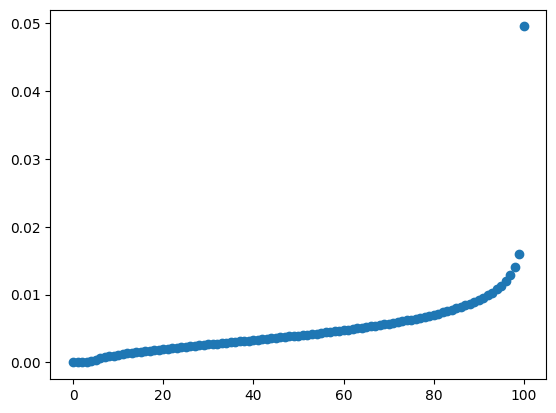

In [14]:
plt.scatter(np.arange(len(separators) + 2), [0, *separators, sorted_pv[-1]])

In [ ]:
target_cpa = 96.69004106767193
total_budget = 3085.854978423787
advertiser = 22
env.reset(budget=total_budget, target_cpa=target_cpa, advertiser=advertiser)
print("Budget:", env.total_budget, "Target cpa:", env.target_cpa, "Advertiser:", env.advertiser, "Period:", env.period)

done = False
while not done:
    flex_action = env.get_oracle_upgrade_action()
    _, _, terminated, truncated, info = env.step(flex_action)

    done = terminated or truncated
print("Flex oracle score:", info["score"])

# flex_score, flex_impressions, flex_slots, flex_ratios, flex_costs, flex_pvs = compute_oracle_upgrade_score(env)
# print("Expected flex oracle score:", flex_score)

In [ ]:
plt.scatter(imp_df.pv, imp_df.cost, s=2, alpha=0.05)
xx = np.linspace(0, imp_df.pv.max(), 100)
plt.plot(xx, realistic_oracle_action * xx * env.target_cpa, color="red")

yy = realistic_oracle_action * env.target_cpa * np.log(200 * xx + 1) * 0.005
plt.plot(xx, yy, color="green")

In [ ]:

from sklearn.linear_model import QuantileRegressor

X = np.log(imp_df.pv.values.reshape(-1, 1) + 1)
y = imp_df.cost
model = QuantileRegressor(quantile=0.95, alpha=0)
model.fit(X, y)

xx = np.linspace(0, imp_df.pv.max(), 100)
yy = model.predict(np.log(xx.reshape(-1, 1) + 1))

plt.scatter(imp_df.pv, imp_df.cost, s=2, alpha=0.05)
plt.plot(xx, yy, color="green")
plt.plot(xx, realistic_oracle_action * xx * env.target_cpa, color="red")


In [ ]:
# for t in range(48):
#     plt.figure()
#     t_df = imp_df[imp_df.time == t]
#     plt.scatter(t_df.pv, t_df.cost, s=2, alpha=0.5)
#     plt.xlim(0, imp_df.pv.max())
#     plt.ylim(0, imp_df.cost.max())
    
#     plt.show()

In [ ]:
# env.reset()
# oracle_action = env.get_oracle_action()
# print(oracle_action)
# simplified_oracle_action = env.get_simplified_oracle_action()
# print(simplified_oracle_action)

# cost_table = np.vstack(env.episode_bids_df.bid)
# exposed_table = np.vstack(env.episode_bids_df.isExposed)
# pvalues_arr = np.concatenate(env.episode_pvalues_df.pValue.to_list())
# time_arr = np.repeat(
#     np.arange(len(env.episode_pvalues_df)),
#     env.episode_pvalues_df.pValue.apply(len),
# )
# exposed_prob = np.mean(exposed_table, axis=0)
# eff_cost_table = cost_table * exposed_prob
# eff_pv_table = np.outer(pvalues_arr, exposed_prob)
# pv_cost_table = eff_pv_table / eff_cost_table

# print("Budget", env.total_budget, "target cpa", env.target_cpa)
# for action in (oracle_action, simplified_oracle_action):
#     num_slot_won = (pv_cost_table * env.target_cpa * action > 1).sum(axis=1)

#     slot_idx = num_slot_won[num_slot_won > 0] - 1
#     total_cost = eff_cost_table[num_slot_won > 0, slot_idx].sum()
#     total_pv = eff_pv_table[num_slot_won > 0, slot_idx].sum()
#     cpa = total_cost / total_pv
#     print("cost: ", total_cost, "pv: ", total_pv, "cpa: ", cpa)
#     score = total_pv * min(1, (env.target_cpa / cpa)**2)
#     print("score: ", score)

In [ ]:
# bid_table = np.vstack(env.episode_bids_df.bid)
# cost_table = np.vstack(env.episode_bids_df.cost)
# full_cost_table = np.concatenate((cost_table, bid_table[:, -1:]), axis=1)
# ad_id_table = np.vstack(env.episode_bids_df.advertiserNumber)
# ad_id_mask = ad_id_table == env.advertiser
# found_mask = np.any(ad_id_mask, axis=1).reshape(-1, 1)
# full_mask = np.concatenate((~found_mask, ad_id_mask), axis=1)

# cost_table = full_cost_table[~full_mask].reshape(-1, 3)

# # cost_table = np.vstack(env.episode_bids_df.bid)
# exposed_table = np.vstack(env.episode_bids_df.isExposed)
# pvalues_arr = np.concatenate(env.episode_pvalues_df.pValue.to_list())

# exposed_prob = np.mean(exposed_table, axis=0)
# eff_cost_table = cost_table * exposed_prob
# eff_pv_table = np.outer(pvalues_arr, exposed_prob)

# # Compute the sum of the cost of the elements at position impression and slot
# cost_sum = np.sum(eff_cost_table[imp_df.impression, imp_df.slot])
# print(cost_sum)
# conversion_sum = np.sum(eff_pv_table[imp_df.impression, imp_df.slot])
# print(conversion_sum)
# cpa = cost_sum / conversion_sum
# score = conversion_sum * min(1, (env.target_cpa / cpa)**2)
# print(score)

In [ ]:
# def prepare_impressions(eff_cost_table, eff_pv_table):
#     slot_3_cost = eff_cost_table[:, 0]
#     upgrade_3_2_cost = eff_cost_table[:, 1] - eff_cost_table[:, 0]
#     upgrade_2_1_cost = eff_cost_table[:, 2] - eff_cost_table[:, 1]
#     upgrade_3_1_cost = eff_cost_table[:, 2] - eff_cost_table[:, 0]
#     slot_3_pv = eff_pv_table[:, 0]
#     upgrade_3_2_pv = eff_pv_table[:, 1] - eff_pv_table[:, 0]
#     upgrade_2_1_pv = eff_pv_table[:, 2] - eff_pv_table[:, 1]
#     upgrade_3_1_pv = eff_pv_table[:, 2] - eff_pv_table[:, 0]
#     slot_3_ratio = slot_3_pv / slot_3_cost
#     upgrade_3_2_ratio = upgrade_3_2_pv / upgrade_3_2_cost
#     upgrade_2_1_ratio = upgrade_2_1_pv / upgrade_2_1_cost
#     upgrade_3_1_ratio = upgrade_3_1_pv / upgrade_3_1_cost

#     # Test
#     # No 3_2 upgrade should be better than slot 3 (see theory)
#     assert (upgrade_3_2_ratio > slot_3_ratio).mean() == 0
#     # No 3_1 upgrade should be better than slot 3 (see theory)
#     assert (upgrade_3_1_ratio > slot_3_ratio).mean() == 0
#     # If 2_1 is better than 3_2, then 3_1 should be better than 3_2 (see theory)
#     assert ((upgrade_2_1_ratio > upgrade_3_2_ratio) == (upgrade_3_1_ratio > upgrade_3_2_ratio)).all()

#     mask = upgrade_3_2_ratio > upgrade_2_1_ratio

#     flat_ratio = np.concatenate((slot_3_ratio, upgrade_3_2_ratio[mask], upgrade_2_1_ratio[mask], upgrade_3_1_ratio[~mask]))
#     flat_eff_cost = np.concatenate((slot_3_cost, upgrade_3_2_cost[mask], upgrade_2_1_cost[mask], upgrade_3_1_cost[~mask]))
#     flat_eff_pv = np.concatenate((slot_3_pv, upgrade_3_2_pv[mask], upgrade_2_1_pv[mask], upgrade_3_1_pv[~mask]))
#     slot_indices = np.concatenate((np.zeros_like(slot_3_ratio), np.ones_like(upgrade_3_2_ratio[mask]), 2*np.ones_like(upgrade_2_1_ratio[mask]), 2*np.ones_like(upgrade_3_1_ratio[~mask])))
#     all_imp = np.arange(eff_cost_table.shape[0])
#     impression_indices = np.concatenate((all_imp, all_imp[mask], all_imp[mask], all_imp[~mask]))
    
#     # Exclude pv equal to 0 - never good and could cause issues in ranking
#     valid_mask = flat_eff_pv > 0
#     flat_ratio = flat_ratio[valid_mask]
#     flat_eff_cost = flat_eff_cost[valid_mask]
#     flat_eff_pv = flat_eff_pv[valid_mask]
#     slot_indices = slot_indices[valid_mask]
#     impression_indices = impression_indices[valid_mask]

#     # Step 4: Rank all impressions by pv/cost ratio (descending)
#     # Exclude the pvalues equal to 0
#     sorted_indices = np.argsort(-flat_ratio)  # negative sign for descending order
    
#     # Return the sorted indices along with corresponding impression and slot
#     sorted_impression_indices = impression_indices[sorted_indices]
#     sorted_slot_indices = slot_indices[sorted_indices]
#     sorted_flat_ratio = flat_ratio[sorted_indices]
#     sorted_flat_eff_cost = flat_eff_cost[sorted_indices]
#     sorted_flat_eff_pv = flat_eff_pv[sorted_indices]
    
#     return sorted_impression_indices, sorted_slot_indices, sorted_flat_ratio, sorted_flat_eff_cost, sorted_flat_eff_pv

# def compute_oracle_upgrade_score(env):
#     cost_table = np.vstack(env.episode_bids_df.bid)
#     exposed_table = np.vstack(env.episode_bids_df.isExposed)
#     pvalues_arr = np.concatenate(env.episode_pvalues_df.pValue.to_list())

#     exposed_prob = np.mean(exposed_table, axis=0)
#     eff_cost_table = cost_table * exposed_prob
#     eff_pv_table = np.outer(pvalues_arr, exposed_prob)

#     sorted_impressions, sorted_slots, sorted_ratios, sorted_eff_costs, sorted_eff_pv = prepare_impressions(eff_cost_table, eff_pv_table)

#     target_cpa = env.target_cpa
#     max_budget = env.total_budget
#     cum_eff_cost = np.cumsum(sorted_eff_costs)
#     cum_eff_pv = np.cumsum(sorted_eff_pv)

#     cum_cpa = cum_eff_cost / cum_eff_pv
#     cum_score = cum_eff_pv * np.minimum(1, (target_cpa / cum_cpa)**2) * (cum_eff_cost <= max_budget)
#     max_score = cum_score.max()
    
#     # Get idx of the max score
#     max_score_idx = np.argmax(cum_score)
    
#     # Return the max score, the impression and slot indices until the max score
#     return max_score, sorted_impressions[:max_score_idx+1], sorted_slots[:max_score_idx+1], sorted_ratios[:max_score_idx+1], sorted_eff_costs[:max_score_idx+1], sorted_eff_pv[:max_score_idx+1]

# flex_score, flex_impressions, flex_slots, flex_ratios, flex_costs, flex_pvs = compute_oracle_upgrade_score(env)
# print("Expected flex oracle score:", flex_score)

# cost_table = np.vstack(env.episode_bids_df.bid)
# exposed_table = np.vstack(env.episode_bids_df.isExposed)
# pvalues_arr = np.concatenate(env.episode_pvalues_df.pValue.to_list())
# time_arr = np.repeat(
#     np.arange(len(env.episode_pvalues_df)),
#     env.episode_pvalues_df.pValue.apply(len),
# )
# exposed_prob = np.mean(exposed_table, axis=0)
# eff_cost_table = cost_table * exposed_prob
# eff_pv_table = np.outer(pvalues_arr, exposed_prob)

# df = pd.DataFrame({
#     "impression": flex_impressions,
#     "slot": flex_slots,
#     "ratio": flex_ratios,
#     "cost": flex_costs,
#     "pv": flex_pvs
# })
# df["slot"] = df["slot"].apply(int)
# imp_df = df.groupby("impression").slot.max().reset_index()
# imp_df["slot"] = imp_df["slot"].apply(int)
# imp_df["pv"] = eff_pv_table[imp_df.impression, imp_df.slot]
# imp_df["cost"] = eff_cost_table[imp_df.impression, imp_df.slot]
# imp_df["time"] = time_arr[imp_df.impression]

# total_pv = imp_df.pv.sum()
# total_cost = imp_df.cost.sum()
# cpa = total_cost / total_pv
# score = total_pv * min(1, (env.target_cpa / cpa)**2)
# print("cost: ", total_cost, "pv: ", total_pv, "cpa: ", cpa, "score: ", score)

# plt.scatter(imp_df.pv, imp_df.cost, s=2, alpha=0.05)
# xx = np.linspace(0, imp_df.pv.max(), 100)
# plt.plot(xx, realistic_oracle_action * xx * env.target_cpa, color="red")


# df = pd.DataFrame({
#     "impression": flex_impressions,
#     "slot": flex_slots,
# })
# df["slot"] = df["slot"].apply(int)
# imp_df = df.groupby("impression").slot.max().reset_index()
# imp_df["slot"] = imp_df["slot"].apply(int)
# imp_df["pv"] = eff_pv_table[imp_df.impression, imp_df.slot]
# imp_df["cost"] = eff_cost_table[imp_df.impression, imp_df.slot]
# imp_df["time"] = time_arr[imp_df.impression]

# total_pv = imp_df.pv.sum()
# total_cost = imp_df.cost.sum()
# cpa = total_cost / total_pv
# score = total_pv * min(1, (env.target_cpa / cpa)**2)
# print("cost: ", total_cost, "pv: ", total_pv, "cpa: ", cpa, "score: ", score)

In [ ]:
df["real_pv"] = eff_pv_table[df.impression, df.slot]
g_df = df.groupby("impression").agg({"real_pv": "max", "pv": "sum"})
print(np.allclose(g_df.pv, g_df.real_pv))

In [ ]:
g_df[g_df.real_pv != g_df.pv]

In [ ]:
g_df.pv.sum()

In [186]:
bid_table = np.vstack(env.episode_bids_df.bid)
cost_table = np.vstack(env.episode_bids_df.cost)
full_cost_table = np.concatenate((cost_table, bid_table[:, -1:]), axis=1)
ad_id_table = np.vstack(env.episode_bids_df.advertiserNumber)
ad_id_mask = ad_id_table == env.advertiser
found_mask = np.any(ad_id_mask, axis=1).reshape(-1, 1)
full_mask = np.concatenate((~found_mask, ad_id_mask), axis=1)

cost_table = full_cost_table[~full_mask].reshape(-1, 3)

# cost_table = np.vstack(env.episode_bids_df.bid)
exposed_table = np.vstack(env.episode_bids_df.isExposed)
pvalues_arr = np.concatenate(env.episode_pvalues_df.pValue.to_list())

exposed_prob = np.mean(exposed_table, axis=0)
eff_cost_table = cost_table * exposed_prob
eff_pv_table = np.outer(pvalues_arr, exposed_prob)

sorted_impressions, sorted_slots, sorted_ratios, sorted_eff_costs, sorted_eff_pv = prepare_impressions(eff_cost_table, eff_pv_table)

In [ ]:
plt.figure()
plt.scatter(np.arange(len(sorted_ratios)), sorted_ratios, s=2)

In [ ]:
# Benchmark execution time for 5 episodes
import time
start = time.time()
for _ in range(5):
    env.reset()
    done = False
    while not done:
        flex_action = env.get_simplified_oracle_action()
        _, _, terminated, truncated, info = env.step(flex_action)
        done = terminated or truncated
print("Simplified oracle execution time:", time.time() - start)

start = time.time()
for _ in range(10):
    env.reset()
    done = False
    while not done:
        flex_action = env.get_realistic_oracle_action()
        _, _, terminated, truncated, info = env.step(flex_action)
        done = terminated or truncated
print("Oracle execution time:", time.time() - start)

In [14]:
def optimize_alpha_with_budget(pv_cost_table, eff_cost_table, eff_pv_table, target_cpa, budget):
    # Initialize values
    n_impressions, n_slots = pv_cost_table.shape
    
    # Step 1: List all impression opportunities
    # np array of shape (n_impressions * n_slots, 3) with columns: id, slot, pv_cost
    impression_ids = np.zeros(n_impressions * n_slots, dtype=int)
    slots = np.zeros(n_impressions * n_slots, dtype=int)
    pv_costs = np.zeros(n_impressions * n_slots, dtype=np.float32)
    
    for i in range(n_impressions):
        for slot in range(n_slots):
            impression_ids[i * n_slots + slot] = i
            slots[i * n_slots + slot] = slot
            pv_costs[i * n_slots + slot] = pv_cost_table[i, slot]

    # Step 2: Sort by pv/cost (descending)
    sort_indices = np.argsort(pv_costs)[::-1]
    impression_ids = impression_ids[sort_indices]
    slots = slots[sort_indices]
    pv_costs = pv_costs[sort_indices]
        
    # Variables to track total cost, total pv, best score, and corresponding alpha
    cum_cost = 0
    cum_pv = 0
    best_score = -np.inf
    best_alpha = None
    
    # Store current slot selection per impression
    current_slot = [-1] * n_impressions  # -1 means no slot is currently selected

    # Store values of cost, pv, cpa, and score at each step
    stored_data = []

    # Step 3: Iterate through the sorted impressions
    for imp_id, new_slot, pv_cost in zip(impression_ids, slots, pv_costs):

        # Remove the old contribution from the previous slot if it was set
        if current_slot[imp_id] != -1:
            prev_slot = current_slot[imp_id]
            cum_cost -= eff_cost_table[imp_id, prev_slot]
            cum_pv -= eff_pv_table[imp_id, prev_slot]
        
        # Add the new contribution for the current slot
        cum_cost += eff_cost_table[imp_id, new_slot]
        cum_pv += eff_pv_table[imp_id, new_slot]
        
        # Update the current slot for this impression
        current_slot[imp_id] = new_slot
        
        # Early termination if cost exceeds the budget
        # if cum_cost > budget:
        #     break
        
        # Compute CPA and score
        cpa = cum_cost / cum_pv if cum_pv > 0 else np.inf
        score = cum_pv * min((target_cpa / cpa)**2, 1)
        
        # Store current total cost, total pv, cpa, and score
        stored_data.append((cum_cost, cum_pv, cpa, score))
        
        # Step 4: Find the maximum score within the budget constraint
        if score > best_score:
            best_score = score
            best_alpha = 1 / pv_cost  # Set alpha as cost / pv of max score

    # Return the best alpha, best score, and the index where the max score occurs
    return best_alpha / target_cpa, best_score, stored_data

In [ ]:
cost_table = np.vstack(env.episode_bids_df.bid)
exposed_table = np.vstack(env.episode_bids_df.isExposed)
pvalues_arr = np.concatenate(env.episode_pvalues_df.pValue.to_list())
time_arr = np.repeat(
                    np.arange(len(env.episode_pvalues_df)),
                    env.episode_pvalues_df.pValue.apply(len),
                )

exposed_prob = np.mean(exposed_table, axis=0)
eff_cost_table = cost_table * exposed_prob
eff_pv_table = np.outer(pvalues_arr, exposed_prob)

pv_cost_table = eff_pv_table / eff_cost_table

# Example call with appropriate inputs
best_alpha, best_score, data = optimize_alpha_with_budget(
    pv_cost_table, eff_cost_table, eff_pv_table, target_cpa=60, budget=5000
)


In [ ]:

costs, pvs, cpas, scores = zip(*data)
x = costs

plt.plot(x, costs, label='Cost')
plt.legend()
plt.show()
plt.plot(x, pvs, label='PV')
plt.legend()
plt.show()
plt.plot(x, cpas, label='CPA')
plt.legend()
plt.show()
plt.plot(x, scores, label='Score')
plt.legend()
plt.show()


In [63]:
n_impressions, n_slots = pv_cost_table.shape

# Step 1: List all impression opportunities
# np array of shape (n_impressions * n_slots, 3) with columns: id, slot, pv_cost
impression_ids = np.zeros(n_impressions * n_slots, dtype=int)
slots = np.zeros(n_impressions * n_slots, dtype=int)
pv_costs = np.zeros(n_impressions * n_slots, dtype=np.float32)
costs = np.zeros(n_impressions * n_slots, dtype=np.float32)
pvs = np.zeros(n_impressions * n_slots, dtype=np.float32)

for i in range(n_impressions):
    for slot in range(n_slots):
        impression_ids[i * n_slots + slot] = i
        slots[i * n_slots + slot] = slot
        pv_costs[i * n_slots + slot] = pv_cost_table[i, slot]
        costs[i * n_slots + slot] = eff_cost_table[i, slot]
        pvs[i * n_slots + slot] = eff_pv_table[i, slot]

# Step 2: Sort by pv/cost (descending)
sort_indices = np.argsort(pv_costs)[::-1]
impression_ids = impression_ids[sort_indices]
slots = slots[sort_indices]
pv_costs = pv_costs[sort_indices]
costs = costs[sort_indices]
pvs = pvs[sort_indices]

In [ ]:
for slot_id in np.unique(slots):
    slot_mask = slots == slot_id
    masked_costs = costs[slot_mask]
    masked_pvs = pvs[slot_mask]
    cum_costs = np.cumsum(masked_costs)
    cum_pvs = np.cumsum(masked_pvs)
    cpas = cum_costs / cum_pvs
    scores = cum_pvs * np.minimum((60 / cpas)**2, 1)
    plt.plot(cum_costs, scores, label=f'Slot {- slot_id + 3}')
    plt.xlabel('Cost')
    plt.ylabel('Score')
plt.legend()

In [ ]:
costs

In [ ]:
env.episode_bids_df.keys()


In [ ]:
env.reset(budget=3000, target_cpa=6, advertiser=0, period=7)
print(env.episode_bids_df.iloc[0].bid[:5])
print(env.episode_bids_df.iloc[0].cost[:5])

env.auction_noise = 0.1
env.reset(budget=3000, target_cpa=6, advertiser=0, period=7)
print(env.episode_bids_df.iloc[0].bid[:5])
print(env.episode_bids_df.iloc[0].cost[:5])

In [ ]:
def noisy_bid_and_cost(row, noise): 
    bid = row['bid']
    cost = row['cost'] 
    second_price_ratio = cost[:, 0] / bid[:, 0]
    
    # Add noise to bids
    noisy_bid = bid * (1 + np.random.uniform(-noise, noise, bid.shape))
    noisy_bid = np.sort(noisy_bid, axis=1)
    noisy_cost = np.zeros_like(noisy_bid)
    noisy_cost[:, 0] = noisy_bid[:, 0] * second_price_ratio
    noisy_cost[:, 1:] = noisy_bid[:, :-1]
    
    # Return the modified noisy_bid and noisy_cost
    return pd.Series([noisy_bid, noisy_cost])

env.reset()
print(env.episode_bids_df.iloc[0].bid[:5])

# Apply the function and directly replace "bid" and "cost" columns
env.episode_bids_df[['bid', 'cost']] = env.episode_bids_df.apply(noisy_bid_and_cost, noise=0.1, axis=1)

# Check the result
print(env.episode_bids_df.iloc[0].bid[:5])

In [ ]:
noise = 0.3
env.reset()
bid = env.episode_bids_df.iloc[0].bid
cost = env.episode_bids_df.iloc[0].cost
second_price_ratio = cost[:, 0] / bid[:, 0]

noisy_bid = bid * (1 + np.random.uniform(-noise, noise, bid.shape))
noisy_bid = np.sort(noisy_bid, axis=1)
noisy_cost = np.zeros_like(noisy_bid)
noisy_cost[:, 0] = noisy_bid[:, 0] * second_price_ratio
noisy_cost[:, 1:] = noisy_bid[:, :-1]

print(bid[:5])
print(noisy_bid[:5])
print(cost[:5])
print(noisy_cost[:5])



In [ ]:
sorted_noisy_bid

In [ ]:
(sorted_noisy_cost == np.sort(sorted_noisy_cost, axis=1)).all()

In [ ]:
sorting_idx = np.argsort(noisy_bid, axis=1)
sorted_noisy_bid = np.take_along_axis(noisy_bid, sorting_idx, axis=1)
(sorted_noisy_bid == np.sort(noisy_bid, axis=1)).all()


In [ ]:
# Measure the execution time of 10 runs
import time
start = time.time()
for _ in range(10):
# Test env execution
    total_budget = 8000
    target_cpa = 8
    advertiser = 0
    period = 7
    state = env.reset(total_budget, target_cpa, advertiser, period)
    topline_action = env.get_oracle_action()
    ranked_df = env.ranked_df
    should_win_count = len(ranked_df[ranked_df.pv_over_cost >= 1. / topline_action.item() / target_cpa])
    print(env.advertiser, env.period, topline_action)
    done = False
    action_list = []
    while not done:
        # action = env.target_cpa * 1.2
        flex_action = env.get_oracle_action()
        # action = topline_action
        action_list.append(flex_action)
        state, reward, terminated, truncated, _ = env.step(flex_action)
        done = terminated or truncated
        # print(f"Action: {action}, Reward: {reward}, Done: {done}")
    print("Conversions:", env.total_conversions)
    print("Cost:", env.total_cost)
    print("Cpa:", env.total_cost / env.total_conversions)
    print("Reward:", reward)

    bids_won_list = [mbs * npv for mbs, npv in zip(env.mean_bid_success_list, env.num_pv_list)]
    bids_won = sum(bids_won_list)
    print("Should win count:", should_win_count, "Bids won:", bids_won)

    # plt.plot(action_list)
# output execution time
end = time.time()
print("Execution time:", end - start)

In [ ]:
# Test env execution
total_budget = 8000
target_cpa = 8
advertiser = 0
period = 7
state = env.reset(total_budget, target_cpa, advertiser, period)
topline_action = env.get_oracle_action()
ranked_df = env.ranked_df
should_win_count = len(ranked_df[ranked_df.pv_over_cost >= 1. / topline_action.item() / target_cpa])
print(env.advertiser, env.period, topline_action)
done = False
action_list = []

In [ ]:

flex_action = env.get_oracle_action()
# action = topline_action
action_list.append(flex_action)
state, reward, terminated, truncated, _ = env.step(flex_action)
done = terminated or truncated
# print(f"Action: {action}, Reward: {reward}, Done: {done}")
print("Action:", flex_action)
print("State:", state)
print("Reward:", reward)
print("Conversions:", env.total_conversions)
print("Cost:", env.total_cost)
print("Cpa:", env.total_cost / env.total_conversions)
print("Reward:", reward)

# bids_won_list = [mbs * npv for mbs, npv in zip(env.mean_bid_success_list, env.num_pv_list)]
# bids_won = sum(bids_won_list)
# print("Should win count:", should_win_count, "Bids won:", bids_won)

# plt.plot(action_list)

In [ ]:
env.target_cpa

In [ ]:
should_win_count_list = []
for ts in range(48):
    should_win_count = len(ranked_df[(ranked_df.pv_over_cost >= 1. / topline_action / target_cpa)
                                     & (ranked_df.time_step == ts)])
    should_win_count_list.append(should_win_count)
plt.plot(should_win_count_list)
plt.plot(bids_won_list)
plt.show()

In [ ]:
# Test env execution
total_budget = 10000
target_cpa = 1
advertiser = 0
period = 7
state = env.reset(total_budget, target_cpa, advertiser, period)
topline_action = env.get_oracle_action()
print(env.advertiser, env.period, topline_action)
done = False
action_list = []
while not done:
    # action = env.target_cpa * 1.2
    flex_action = env.get_oracle_action()
    action_list.append(flex_action)
    state, reward, terminated, truncated, _ = env.step(flex_action)
    done = terminated or truncated
    # print(f"Action: {action}, Reward: {reward}, Done: {done}")
print("Conversions:", env.total_conversions)
print("Cost:", env.total_cost)
print("Cpa:", env.total_cost / env.total_conversions)
print("Reward:", reward)

plt.plot(action_list)

In [ ]:
conversion_list = [c * pv for c, pv in zip(env.mean_conversion_list, env.num_pv_list)]


import matplotlib.pyplot as plt

plt.plot(conversion_list)